In [13]:
from qutip import *
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
from scipy.special import genlaguerre as L
from scipy.integrate import solve_ivp as solve
from scipy.integrate import odeint
import time

To save time and space anytime rho appears without a specific mention of an element of rho (like rhogg), rho will be defined as rho = [rhogg, rhoee, rhoeg]. As such, when we have multiple harmonic osc states, rho[n] = [rhogg, rhoee, rhoeg] and rho = [rho[0], rho[1] ...]

Update: we need rho to be 1D to be compatible with the integrater. So now rhoggn = rho[3n], rhoeen = rho[3n+1], and rhogen = rho[3n+2]

In [241]:
def prob(n,nbar):
    return 1.0/(nbar+1)*(nbar/(nbar+1))**n    #returns prob of being in state n given nbar

def dopAndStark(n):       #for 1D!! to make 3d, multiply this by 3                        
    return -2.0*np.pi*nu0*hbar*omega*(n+0.5)/(m*c**2)*(1.0 + alpha*m**2*Omegarf**2*c**2/(h*nu0*e**2*2)) 

def Omega(n,m,eta):
    return np.exp(-eta**2/2.0) * eta**(np.abs(m)) * (math.factorial(n)/math.factorial(n+m))**(np.sign(m)/2.0) \
        * L(n,np.abs(m))(eta**2)              #returns unitless rabi rate of transition n -> n+m given Lamb-Dicke Parameter

def fastOmega(n,m,eta):
    return 1.0 - eta**2.0*n

eta = 0.05
omegas = np.zeros(2000)
for ii in range(np.size(omegas)):
    omegas[ii] = Omega(ii,0,eta)

In [168]:
#def groundRho(Ncut):
#    rho = np.array([[0.0+0.0j]*3]*(Ncut+1))
#    rho[0][0] = 1.0+0.0j
#    rho = np.reshape(rho, (Ncut+1)*3)
#    return rho

def groundRho(Ncut, nbar):
    rho = np.array([0.0+0.0j]*3*(Ncut+1))
    for n in range(Ncut):
        rho[3*n] = prob(n,nbar)
    return rho

def heatSys(t, rho, nbardot):
    Ncut = rho.shape[0]//3 - 1
    rhoDot = [0.0+0.0j]*((Ncut+1)*3)
    for ii in range(3):
        rhoDot[0+ii] = nbardot*(-rho[0+ii]+rho[3*1+ii])
        rhoDot[3*Ncut+ii] = nbardot*(-Ncut*rho[3*Ncut+ii]+Ncut*rho[3*(Ncut-1)+ii])
        #Note*** the above line is true in the limit that rho[Ncut+1,ii]=rho[Ncut,ii] (fair assumption for large Ncut I think)
        for n in range(1,Ncut-1):
            rhoDot[3*n+ii] = nbardot*(-(2.0*n+1.0)*rho[3*n+ii] + (n+1.0)*rho[3*(n+1)+ii] + n*rho[3*(n-1)+ii])
    return rhoDot

def subFreeEvo(rho0, phi):
    return np.array([rho0[0], rho0[1], rho0[2]*np.exp(-1.0j*phi)])

def freeEvo(rho0, phi):
    Ncut = rho0.size//3 - 1
    rho = np.array([0.0+0.0j]*3*(Ncut+1))
    for n in range(Ncut):
        rho[3*n:3*(n+1)] = subFreeEvo(rho0[3*n:3*(n+1)], phi)
    return rho

def nbar(rho):
    Ncut = rho.shape[0]//3
    nbar = 0.0
    for n in range(Ncut):
        nbar += n*(rho[n*3].real + rho[n*3+1].real)
    return nbar

def rhogg(rho):
    rhogg = 0.0
    Ncut = rho.shape[0]//3
    for n in range(Ncut):
        rhogg += rho[(3*n)].real
    return rhogg

def rhoee(rho):
    rhoee = 0.0
    Ncut = rho.shape[0]//3
    for n in range(Ncut):
        rhoee += rho[(3*n)+1].real
    return rhoee

In [29]:
def heat(rho, t, nbardot):
    rho = solve(heatSys, [0.0,t], rho, args=[nbardot]).y[:,-1]
    return rho

def ramsey(rho0, T, deld, delPrime, Omega0):
    #T = dark-time, deld = dark-time detuning, delPrime=pulse detuning
    rho = solve(bloch, [0.0, np.pi/(2.0*Omega0)], rho0, args=(Omega0, delPrime)).y[:,-1]
    rho = freeEvo(T, rho, deld)
    rho = solve(bloch, [0.0, np.pi/(2.0*Omega0)], rho, args=(Omega0, delPrime)).y[:,-1]
    return rho

In [244]:
#takes rho as a 3 element vector and converts it to a 2x2 matrix by calculating the conj. of rhoge
def subpulse(rho0, t, Omega0, delta):
    rho = np.array([[rho0[0], rho0[2]],[np.conj(rho0[2]), rho0[1]]])
    Omega = np.sqrt(Omega0**2 + delta**2)
    if Omega == 0.0:
        U = np.array([[1.0 , 0.0],
                      [0.0 , 1.0]])
    else:
        U = np.array([[np.cos(Omega*t/2.0) -(1.0j*delta/Omega)*np.sin(Omega*t/2.0), (1.0j*Omega0/Omega)*np.sin(Omega*t/2.0)],
                     [(1.0j*Omega0/Omega)*np.sin(Omega*t/2.0) , np.cos(Omega*t/2.0) + (1.0j*delta/Omega)*np.sin(Omega*t/2.0)]])
    rho = U@rho@np.conj(U)
    return np.array([rho[0,0], rho[1,1], rho[0,1]])

def pulse(rho0, t, Omega0, delta):
    Ncut = rho0.size//3 - 1
    rho = np.array([0.0+0.0j]*3*(Ncut+1))
    for n in range(Ncut):
        rho[3*n:3*(n+1)] = subpulse(rho0[3*n:3*(n+1)], t, Omega0*omegas[n], delta)
    return rho

In [123]:
rho0 = groundRho(3, 0.0)
Omega0 = np.pi/2.0
pts = 100
ts = np.linspace(0,10, pts)
delPrime = 1.0
eta = 0.0
rhoees = np.zeros(pts)

for ii in range(pts):
    rhoees[ii] = rhoee(pulse(rho0, ts[ii], Omega0, delPrime))

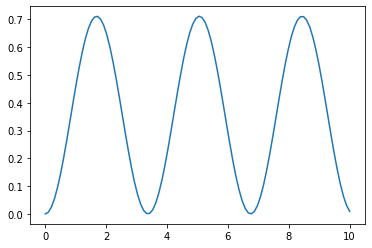

In [124]:
plt.plot(ts, rhoees)

In [242]:
def ramsey(rho0, t1, T, t2, deld, delPrime, Omega0):
    intState = freeEvo(pulse(rho0, t1, Omega0, delPrime), deld*T)
    result = pulse(intState, t2, Omega0, delPrime)
    return result

def RamseyErrSig(deld, rho0, t1, T, t2, delPrime, Omega0):
    intState = freeEvo(pulse(rho0, t1, Omega0, delPrime), deld*T)
    resultP = pulse(freeEvo(intState, np.pi/2.0), t2, Omega0, delPrime)
    resultM = pulse(freeEvo(intState, -np.pi/2.0), t2, Omega0, delPrime)                   
    return rhoee(resultP) - rhoee(resultM)

def HRSJumpErrSig(deld, rho0, t1, T, t2, delPrime, Omega0):
    intState = freeEvo(pulse(rho0, t1, Omega0, delPrime), deld*T)
    resultP = pulse(pulse(freeEvo(intState,np.pi/2.0),2.0*t2/3.0,-Omega0,delPrime),t2/3.0,Omega0,delPrime)
    resultM = pulse(pulse(freeEvo(intState,-np.pi/2.0),2.0*t2/3.0,-Omega0,delPrime),t2/3.0,Omega0,delPrime)
    return rhoee(resultP) - rhoee(resultM)

def HRSErrSig(deld, rho0, t1, T, t2, delPrime, Omega0):
    intState = freeEvo(pulse(rho0, t1, Omega0, delPrime), deld*T)
    resultP = pulse(freeEvo(intState,np.pi/2.0),t2,Omega0,delPrime)
    resultM = pulse(freeEvo(intState,-np.pi/2.0),t2,Omega0,delPrime)
    return rhoee(resultP) - rhoee(resultM)

In [233]:
rho0 = groundRho(10, 0.0)
pts = 1000
deltas = np.linspace(-5.5, 5.5, pts)
rhoees = np.zeros(pts)
t1 = np.pi/2.0
t2 = 3.0*t1
T = 20.0
Omega0 = 1.0
for ii in range(pts):
    rhoees[ii] = rhoee(ramsey(rho0, t1, T, t2, deltas[ii], deltas[ii], Omega0, 0.0))

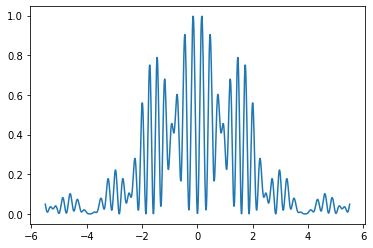

In [235]:
plt.plot(deltas, rhoees)
#deltas

In [217]:
pts = 101
deld = 0.0
rho0 = groundRho(10, 0.0)
t1 = np.pi/2.0
T = 1.0
t2 = 3.0*np.pi/2.0
delPrime = np.linspace(-5.0, 5.0, pts)
Omega0 = 1.0
eta = 0.0
sigPts = np.zeros(pts)
for ii in range(pts):
    sigPts[ii] = HRSErrSig(deld, rho0, t1, T, t2, delPrime[ii], Omega0, eta)

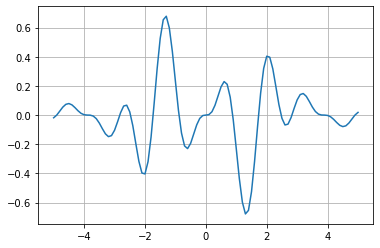

In [218]:
plt.plot(delPrime, sigPts)
plt.grid()

In [249]:
t1 = np.pi/2.0
t2 = 3.0*t1
Omega0 = np.pi/(2.0*t1) #hz
T = 1.0
eta = 0.0
rho0 = groundRho(1000, 0.0)
rho0 = heat(groundRho(1000, 0.0), 1.0, 1.0)

pts = 30
delPrimes = np.linspace(0, 1.5, pts)
delta1s = np.zeros(pts)
guessTol = 0.2
x0 = -0.1
x1 = 0.0

start = time.time()
for ii in range(pts):
    print(x0,x1)
    delta1s[ii] = sp.optimize.root_scalar(HRSErrSig, args=(rho0, t1, T, t2, delPrimes[ii], Omega0), bracket=[x0,x1], xtol = 1e-5).root
    x0 = delta1s[ii] - guessTol
    x1 = delta1s[ii] + guessTol
    print(delta1s[ii])

end = time.time()
print("time= ",end-start)

-0.1 0.0
0.0
-0.2 0.2
0.0007933246299610006
-0.199206675370039 0.20079332462996102
-0.0010137716613243131
-0.20101377166132434 0.19898622833867569
-0.007688890996483192
-0.20768889099648322 0.1923111090035168
-0.020938238248567335
-0.22093823824856734 0.17906176175143268
-0.041829242449860034
-0.24182924244986004 0.15817075755013998
-0.07084613232593563
-0.27084613232593563 0.1291538676740644
-0.1080217616903335
-0.3080217616903335 0.0919782383096665
-0.1530886971095081
-0.3530886971095081 0.04691130289049192
-0.20561277163890393
-0.40561277163890397 -0.005612771638903918
-0.2650941712830835
-0.4650941712830835 -0.06509417128308348
-0.3310356101691794
-0.5310356101691793 -0.13103561016917936
-0.4029836685020592
-0.6029836685020592 -0.20298366850205918
-0.4805505829805994
-0.6805505829805993 -0.2805505829805994
-0.5634220513543552
-0.7634220513543553 -0.3634220513543552
-0.6513512420208917
-0.8513512420208917 -0.45135124202089166
-0.7441050869392007
-0.9441050869392007 -0.54410508693920

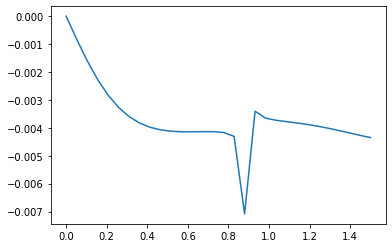

In [252]:
plt.plot(delPrimes, (deltas-delta1s))#/deltas)
#plt.plot(delPrimes, delta1s)

In [179]:
pts = 101
deld = 0.0
rho0 = groundRho(10, 0.0)
t1 = np.pi/2.0
T = 1.0
t2 = np.pi/2.0
delPrime = np.linspace(-5.0, 5.0, pts)
Omega0 = 1.0
eta = 0.0
sigPts = np.zeros(pts)
for ii in range(pts):
    sigPts[ii] = RamseyErrSig(deld, rho0, t1, T, t2, delPrime[ii]+1.0, Omega0)

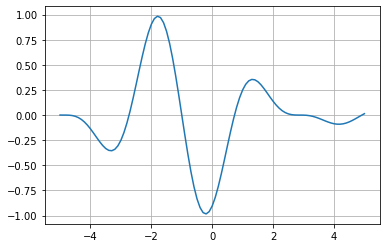

In [180]:
plt.plot(delPrime, sigPts)
plt.grid()

In [150]:
pts = 101
deld = 0.0
rho0 = groundRho(10, 0.0)
t1 = np.pi/2.0
T = 1.0
t2 = np.pi/2.0
delPrime = np.linspace(-10.0, 10.0, pts)
Omega0 = 1.0
eta = 0.0
sigPts = np.zeros(pts)
for ii in range(pts):
    sigPts[ii] = rhogg(ramsey(rho0, t1, T, t2, deld, delPrime[ii]-2.5, Omega0))

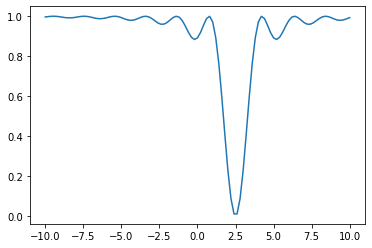

In [151]:
plt.plot(delPrime, sigPts)

In [ ]:
# def fastSubPulse(rho, t, Omega0, delta):
#     Omega = np.sqrt(Omega0**2 + delta**2)
#     if Omega == 0.0:
#         U = np.array([[1.0 , 0.0],
#                       [0.0 , 1.0]])
#     else:
#         phi = Omega*t/2.0
#         U112 = np.cos(phi)**2 + (delta*np.sin(phi)/Omega)**2
#         U11U12 = delta*Omega0*(np.sin(phi)/Omega)**2 + 1.0j*Omega0*np.cos(phi)*np.sin(phi)/Omega
#         U122 = -(Omega0*np.sin(phi)/Omega)**2
#         return np.array([U112*rho[0] -2.0*np.real(U11U12*rho[2]) - U122*rho[2],
#                         -U122*rho[0]-2.0j*np.imag(U11U12*rho[2]) + U112*rho[1],
#                         U11U12*(rho[1]-rho[0]) - U122*np.conj(rho[2]) + rho[2]*(np.cos(phi)**2 - (delta*np.sin(phi)/Omega)**2
#                                                                                -2.0j*delta*np.cos(phi)*np.sin(phi)/Omega)
#                         ])
    
# def fastPulse(rho, t, Omega0, delta, eta):
#     Ncut = rho.size//3 - 1
#     for n in range(Ncut):
#         rho[3*n:3*(n+1)] = fastSubPulse(rho[3*n:3*(n+1)] , t, Omega0*Omega(n,0,eta), delta)
#     return rho

In [45]:
rho0 = groundRho(1000, 0.0)
start = time.time()
rho = pulse(groundRho(1000, 0.0), 1.0, np.pi/2.0, 0.0, 0.0)
end = time.time()
print("time= ",end-start)

time=  0.03191542625427246


In [48]:
print("nbar=",nbar(rho0))
start = time.time()
rho = heat(rho0, 1.0, 1.0)
end = time.time()
print("time= ",end-start)
print("nbar=", nbar(rho))

nbar= 0.0
time=  0.9873306751251221
nbar= 1.0000000000000007


In [54]:
#rho0 = groundRho(1000, 0.0)
start = time.time()
rho = pulse(groundRho(1000, 0.0), 1.0, np.pi/2.0, 0.0, 0.0)
rho = heat(rho, 1.0, 1.0)
end = time.time()
print("time= ",end-start)
print("nbar=", nbar(rho))
print("rhoee=", rhoee(rho))

time=  1.1409461498260498
nbar= 1.0000000000000004
rhoee= 0.5000000000000002


In [90]:
for n in range(5):
    print(n)

0
1
2
3
4
